Intro

In [2]:
import pandas as pd
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

In [27]:
fasta_amostras_file = "../data_prep/omic_data/H3N2_HA_Merged_Complete.fasta"
fasta_vacinas_file="../data_prep/omic_data/vaccine_sequences.fasta"
output_fasta = "../data_prep/omic_data/alignment_proteins.fasta"

# Dicionário para renomear as vacinas
mapping_vacinas = {
    "OQ350818.1": "HK2014",
    "MG974450.1": "KAN2017",
    "OR533546.1": "TAS2020",
    "PX230021.1": "DAR2021",
    "OP213690.1": "MAS2022"
}

def find_cds_and_translate(sequence):
    # Procura o primeiro ATG e traduz a partir daí
    start_idx = sequence.find("ATG")
    if start_idx != -1:
        # Traduz até o primeiro Stop codon
        return sequence[start_idx:].translate(to_stop=True)
    return sequence.translate(to_stop=True)

# 1. Carregar as 5 vacinas (ADN)
vacinas_dna = list(SeqIO.parse(fasta_vacinas_file, "fasta"))
# 2. Carregar as 240 amostras (ADN)
amostras_dna = list(SeqIO.parse(fasta_amostras_file, "fasta"))

lista_proteinas = []

for vac in vacinas_dna:
    prot_seq = find_cds_and_translate(vac.seq)
    
    # Tenta encontrar o nome amigável, se não encontrar mantém o original
    novo_id = mapping_vacinas.get(vac.id, vac.id)
    
    lista_proteinas.append(SeqRecord(prot_seq, id=novo_id, description="VACINA"))

# Traduzir amostras
for amostra in amostras_dna:
    prot_seq = find_cds_and_translate(amostra.seq)
    lista_proteinas.append(SeqRecord(prot_seq, id=amostra.id, description="AMOSTRA"))

# 3. Guardar tudo num único ficheiro para o alinhamento
SeqIO.write(lista_proteinas, output_fasta, "fasta")
print("Ficheiro pronto para alinhamento!")

Ficheiro pronto para alinhamento!


c:\Users\Alexandre\AppData\Local\Programs\Python\Python312\Lib\site-packages\Bio\Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


Foram alinhadas no MAFFT, resultado: aligned_proteins.fasta

Base do dataset:


1- Hamming distance

In [20]:
def hamming_distance(s1, s2):
    # Ignora gaps (-) no cálculo da distância para não penalizar seqs parciais nas pontas
    return sum(1 for a, b in zip(s1, s2) if a != b and a != "-" and b != "-")

In [ ]:
aligned_fasta=list(SeqIO.parse("../data_prep/omic_data/aligned_proteins.fasta", "fasta"))


vacinas=[protein for protein in aligned_fasta if protein.description.split()[1] == 'VACINA']
amostras=[protein for protein in aligned_fasta if protein.description.split()[1] == 'AMOSTRA']

dict_vacinas={}
for vacina in vacinas:
    dict_vacinas [vacina.id]= vacina.seq

rows = []
for amostra in amostras:
    accession = amostra.id.split('.')[0]
    seq_str = str(amostra.seq)

    row = {
        'id': accession,
        # Features Genéticas (Distâncias)
        'dist_HK2014': hamming_distance(seq_str,dict_vacinas['HK2014']),
        'dist_KAN2017': hamming_distance(seq_str,dict_vacinas['KAN2017']),
        'dist_TAS2020': hamming_distance(seq_str,dict_vacinas['TAS2020']),
        'dist_DAR2021': hamming_distance(seq_str,dict_vacinas['DAR2021']),
        'dist_MAS2022': hamming_distance(seq_str,dict_vacinas['MAS2022']),
    }
    rows.append(row)

# 6. Gerar o DataFrame Final
dataset_ml = pd.DataFrame(rows)


print(f"Sucesso! Processadas {len(amostras)} amostras.")
print(f"Colunas criadas: {dataset_ml.columns.tolist()}")
    

Sucesso! Processadas 240 amostras.
Colunas criadas: ['id', 'dist_HK2014', 'dist_KAN2017', 'dist_TAS2020', 'dist_DAR2021', 'dist_MAS2022']


In [77]:
dataset_ml

,id,dist_HK2014,dist_KAN2017,dist_TAS2020,dist_DAR2021,dist_MAS2022
0,MK898525,9,16,20,26,33
1,MK502696,7,15,18,24,31
2,MK400756,7,15,18,24,31
3,MK400758,7,15,18,24,31
4,MK381485,7,15,18,24,31
...,...,...,...,...,...,...
235,LC155875,24,25,33,38,43
236,LC155888,21,20,31,36,41
237,LC155876,22,21,29,34,39
238,LC155892,23,24,30,35,39


2-Collection date

Não adicionamos já ao df_ML para poder testar posteriormente se melhora o modelo ou não

In [ ]:
def date_to_decimal(date_str):
    try:
        dt = pd.to_datetime(date_str)
        year_part = dt.year
        # Calcula a fração do ano decorrida
        day_of_year = dt.timetuple().tm_yday
        is_leap = (year_part % 4 == 0 and (year_part % 100 != 0 or year_part % 400 == 0))
        days_in_year = 366 if is_leap else 365
        return year_part + (day_of_year / days_in_year)
    except:
        return None

Adicionamos ao df de metadados

In [141]:
metadados = pd.read_csv('../data_prep/omic_data/Metadados_H3N2_HA_Complete.csv')

Decimal_Date=[]
for _,row in metadados.iterrows():
    date= row['Collection_Date']
    Decimal_Date.append(date_to_decimal(date))

metadados['Decimal_Date']=Decimal_Date

3-pEpitope

pEpitope é um proxy de escape antigénico / falha vacinal -> o nosso Y

DOI:10.1016/j.vaccine.2019.03.068
https://doi.org/10.1016/j.vaccine.2004.08.028

In [165]:
epitopos = {
    "A": [122, 124, 126, 130, 131, 132, 133, 135, 137, 138, 140,
          142, 143, 144, 145, 146, 150, 152, 168],

    "B": [128, 129, 155, 156, 157, 158, 159, 160, 163, 165,
          186, 187, 188, 189, 190, 192, 193, 194, 196, 197, 198],

    "C": [44, 45, 46, 47, 48, 50, 51, 53, 54,
          273, 275, 276, 278, 279, 280,
          294, 297, 299, 300, 304, 305,
          307, 308, 309, 310, 311, 312],

    "D": [96, 102, 103, 117, 121, 167,
          170, 171, 172, 173, 174, 175, 176, 177,
          179, 182, 201, 203,
          207, 208, 209,
          212, 213, 214, 215, 216, 217, 218, 219,
          226, 227, 228, 229, 230,
          238, 240, 242, 244,
          246, 247, 248],

    "E": [57, 59, 62, 63, 67, 75, 78,
          80, 81, 82, 83,
          86, 87, 88,
          91, 92, 94, 109,
          260, 261, 262, 265]
}

def get_vaccine(decimal_date):
      year=int(decimal_date)
      if year <= 2016:
            ref_id = 'HK2014'
      elif 2017 <= year <= 2019:
            ref_id = 'KAN2017'
      elif year == 2020:
            ref_id = 'TAS2020'
      elif year == 2021:
            ref_id = 'DAR2021'
      else: # 2022, 2023, 2024, 2025
            ref_id = 'MAS2022'
            
      return ref_id

def calculate_pepitope(seq, vaccine_seq):

      p_epitope_dict={}

      for name,positions in epitopos.items():

            mismatch=0
      
            for pos in positions:
                 
                  if seq[pos-1]!= vaccine_seq[pos-1]: #as posições dos epitopos são contadas a apartir do 1, não do 0 como em python
                        mismatch+=1
            
            p_epitope_dict[name]=mismatch/len(positions)

      dominant_epitope_name = max(p_epitope_dict, key=p_epitope_dict.get)
      dominant_epitope_value = p_epitope_dict[dominant_epitope_name]
      return dominant_epitope_value
                  


In [182]:
p_epitopes=[]
for amostra in amostras:
    accession=amostra.id.split('.')[0]
    seq=amostra.seq
    Decimal_Date= metadados[metadados['Accession'] == accession]['Decimal_Date']
    vaccine_id= get_vaccine(Decimal_Date)
    vaccine_seq=dict_vacinas[vaccine_id]

    p_epitopes.append(round(calculate_pepitope(seq,vaccine_seq),5))


dataset_ml['target_p_epitope']=p_epitopes

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_72304\2213697776.py:30: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  year=int(decimal_date)


$0.02$ a $0.10$ (Deriva Ligeira): Indica uma proteção vacinal ainda eficaz. O vírus começou a mudar, mas o sistema imunitário treinado pela vacina ainda reconhece bem a proteína.

$0.10$ a $0.18$ (Deriva Moderada): A eficácia da vacina começa a cair significativamente.

$0.19048$ (O "Limite de Falha"): Este valor é emblemático. Na literatura de Deem, o valor de $0.19$ é frequentemente citado como o limiar crítico de escape.

Anos em que a vacina "falhou" (como 2003/04 e 2014/15) apresentavam valores de $p_{Epitope}$ em torno de 0.19.Segundo a equação de eficácia ($VE = -2.47 \times p_{Epitope} + 0.47$), quando o $p_{Epitope}$ atinge ~0.19, a eficácia teórica da vacina aproxima-se de zero.

4-Distancia à sequencia consenso do dataset

In [ ]:
consensus_seq=[]
for i in range(len(amostras[0].seq)):
    aa_col=[]
    for amostra in amostras:
        aa=amostra.seq[i]
        aa_col.append(aa)

    consensus_aa = max(aa_col, key=aa_col.count)
    consensus_seq.append(consensus_aa)
consensus_seq=''.join(consensus_seq)

Consensus_dist=[]

for amostra in amostras:
    seq=amostra.seq
    dist=hamming_distance(seq,consensus_seq)
    Consensus_dist.append(dist)

dataset_ml.insert(6,'dist_consensus',Consensus_dist)

In [219]:
dataset_ml.iloc[:10]

,id,dist_HK2014,dist_KAN2017,dist_TAS2020,dist_DAR2021,dist_MAS2022,dist_consensus,target_p_epitope
0,MK898525,9,16,20,26,33,7,0.09756
1,MK502696,7,15,18,24,31,5,0.09756
2,MK400756,7,15,18,24,31,5,0.09756
3,MK400758,7,15,18,24,31,5,0.09756
4,MK381485,7,15,18,24,31,5,0.09756
5,MH885205,7,15,18,24,31,5,0.09756
6,MH779033,7,15,18,24,31,5,0.09756
7,MH779034,7,15,18,24,31,5,0.09756
8,MK381488,8,16,19,25,32,6,0.09756
9,MK400757,8,16,18,24,31,6,0.09756


Machine Learning

Ridge Regression

Treino do modelo:
temporally stratified split

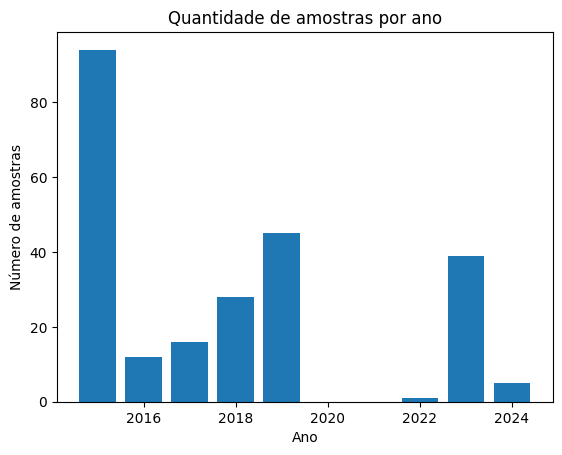

In [222]:
import matplotlib.pyplot as plt
contagem_por_ano = (
    metadados["Year"]
    .value_counts()
    .sort_index()
)
plt.figure()
plt.bar(contagem_por_ano.index, contagem_por_ano.values)
plt.xlabel("Ano")
plt.ylabel("Número de amostras")
plt.title("Quantidade de amostras por ano")
plt.show()


Due to sparse sampling during 2020–2021, a strict chronological split was not feasible. Therefore, a biologically motivated temporal cutoff was adopted, preserving recent post-pandemic strains for evaluation.

In [ ]:
dataset_ml.insert(7,'Year',metadados['Year'])

In [236]:
train_df = dataset_ml[dataset_ml["Year"] <= 2018]
test_df  = dataset_ml[dataset_ml["Year"] >= 2019]

X_train = train_df.drop(columns=["id", "target_p_epitope", "Year"])
y_train = train_df["target_p_epitope"]

X_test  = test_df.drop(columns=["id", "target_p_epitope", "Year"])
y_test  = test_df["target_p_epitope"]


In [237]:
print("Train years:")
print(train_df["Year"].value_counts().sort_index())

print("\nTest years:")
print(test_df["Year"].value_counts().sort_index())


Train years:
Year
2015    94
2016    12
2017    16
2018    28
Name: count, dtype: int64

Test years:
Year
2019    45
2022     1
2023    39
2024     5
Name: count, dtype: int64


In [247]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

y_pred = ridge_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Erro Médio Quadrático (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Erro Médio Quadrático (MSE): 0.0020
R² Score: -0.5346
Root Mean Squared Error (RMSE): 0.0452


Em média, o modelo erra cerca de 4–5% da escala total do pEpitope

O R^2 negativo era de esperar visto que:
Linear models trained on pre-pandemic strains struggle to extrapolate antigenic evolution following major selective shifts.This motivated the use of non-linear models.

Random Forest

In [245]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"RF RMSE: {rmse_rf:.4f}")
print(f"RF R²: {r2_rf:.4f}")

RF RMSE: 0.0307
RF R²: 0.2940


Em média, o modelo erra cerca de ~3% da escala total do pEpitope. Muito bom para dados biológicos reais

Quanto ao R^2: ~30% da variância explicada em extrapolação temporal

In [246]:
importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

importances

,Feature,Importance
0,dist_HK2014,0.343932
4,dist_MAS2022,0.285945
1,dist_KAN2017,0.177780
3,dist_DAR2021,0.088971
5,dist_consensus,0.063201
2,dist_TAS2020,0.040169


Melhorar modelo, mais features, mudar parametros, mudar o split ????